In [26]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re

## Read dataset

In [10]:
def preprocess_dataset(path):
    rows = []
    with open('../../data/dataset_1937770_3.txt', encoding='utf-8') as f:
        for line in f:
            line = line.rstrip('\n')
            # split only on first comma:
            id_part, rest = line.split(',', 1)
            rows.append([id_part, rest])

    df = pd.DataFrame(rows[1:], columns=rows[0])
    return df

df_test = preprocess_dataset('../../data/dataset_1937770_3.txt')
df_test.head()

,id,text_no_spaces
0,0,куплюайфон14про
1,1,ищудомвПодмосковье
2,2,сдаюквартирусмебельюитехникой
3,3,новыйдивандоставканедорого
4,4,отдамдаромкошку


In [11]:
df_test.iloc[101, :]

id                                           101
text_no_spaces    новыймонитор,27дюймов,доставка
Name: 101, dtype: object

In [22]:
df_test.describe()

,id,text_no_spaces
count,1005,1005
unique,1005,1005
top,1004,Весна-гдемояголова?
freq,1,1


## EDA on dataset

### Length of texts

Statistics for text lengths:
count    1005.000000
mean       22.860697
std         7.213070
min         4.000000
25%        18.000000
50%        22.000000
75%        28.000000
max        56.000000
Name: length, dtype: float64

Counts per text length (first few):
length
4      1
5      4
6      1
7      4
8      2
9      3
10     4
11     7
12    16
13    21
14    35
15    43
16    46
17    64
18    59
19    58
20    65
21    58
22    45
23    40
Name: count, dtype: int64

… and some of the longer ones:
length
27    37
28    30
29    31
30    27
31    30
32    20
33    21
34    29
35    11
36    15
37    10
38     9
39     6
40     2
41     2
43     2
44     4
45     1
46     1
56     1
Name: count, dtype: int64


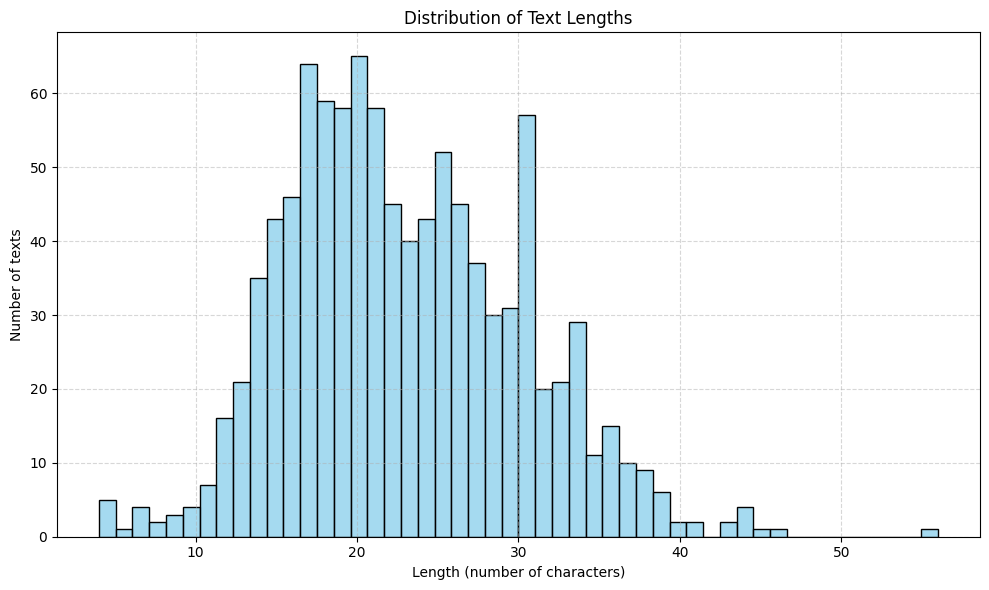

In [28]:
df_test['length'] = df_test['text_no_spaces'].str.len()

print("Statistics for text lengths:")
print(df_test['length'].describe())  # gives count, mean, std, min, quartiles, max

length_counts = df_test['length'].value_counts().sort_index()
print("\nCounts per text length (first few):")
print(length_counts.head(20))
print("\n… and some of the longer ones:")
print(length_counts.tail(20))

plt.figure(figsize=(10, 6))
sns.histplot(df_test['length'], bins=50, kde=False, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Length (number of characters)')
plt.ylabel('Number of texts')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Texts are not very long, we can use models that don't have big context window

### Char counts

In [15]:
texts = df_test['text_no_spaces'].fillna('').astype(str)

counter = Counter()
for text in texts:
    counter.update(text)

char_counts = pd.DataFrame(counter.items(), columns=['char', 'count'])
char_counts = char_counts.sort_values(by='count', ascending=False).reset_index(drop=True)

print(char_counts.head(30))

char_counts.to_csv('../../data/char_frequency.csv', index=False, encoding='utf-8')

   char  count
0     о   2192
1     а   1716
2     е   1585
3     т   1275
4     н   1274
5     и   1251
6     р   1019
7     с   1001
8     у    979
9     л    920
10    к    919
11    в    793
12    д    773
13    м    741
14    п    611
15    ,    429
16    я    425
17    ы    396
18    ь    382
19    б    356
20    г    313
21    й    308
22    ю    299
23    з    296
24    ч    265
25    ж    196
26    ш    176
27    щ    167
28    х    166
29    .    156


In [21]:
char_counts.get(' ', 0)

0

There are no partly lost spaces in texts: texts completely dont have spaces. That's why, when creating training dataset, we only need to remove ALL spaces, not randomly sample some of them to dissappear

### Language check

In [16]:
def categorize_char(ch):
    """Return category: 'ru', 'en', or 'other'."""
    # Russian letters: Unicode ranges for Cyrillic block
    # Lowercase и uppercase
    # U+0400–U+04FF covers many Cyrillic, including Russian letters
    # Also supplementar Cyrillic blocks (if needed)
    code = ord(ch)
    if (0x0400 <= code <= 0x04FF) or (0x0500 <= code <= 0x052F):  
        return 'ru'
    # English/Latin letters
    elif ('a' <= ch <= 'z') or ('A' <= ch <= 'Z'):
        return 'en'
    else:
        return 'other'

def count_char_categories(texts):
    counts = Counter()
    for text in texts:
        for ch in text:
            cat = categorize_char(ch)
            counts[cat] += 1
    return counts

In [17]:
# Get counts
char_cat_counts = count_char_categories(texts)

total_chars = sum(char_cat_counts.values())
print("Character category counts:")
for cat in ['ru', 'en', 'other']:
    cnt = char_cat_counts.get(cat, 0)
    print(f"  {cat}: {cnt} ({cnt/total_chars:.2%} of all chars)")

# If you also want “unique” characters in each category
# and what they are:
unique = {'ru': set(), 'en': set(), 'other': set()}
for text in texts:
    for ch in text:
        unique[categorize_char(ch)].add(ch)
print("\nUnique characters per category:")
for cat in unique:
    print(f"  {cat}: {len(unique[cat])}, sample: {list(unique[cat])[:20]}")

Character category counts:
  ru: 21693 (94.42% of all chars)
  en: 498 (2.17% of all chars)
  other: 784 (3.41% of all chars)

Unique characters per category:
  ru: 58, sample: ['У', 'ё', 'р', 'К', 'ц', 'Х', 'б', 'Л', 'д', 'п', 'Б', 'Ч', 'з', 'М', 'З', 'Р', 'Э', 'к', 'ш', 'я']
  en: 46, sample: ['D', 'r', 'W', 'R', 'p', 'Y', 'B', 'v', 'e', 'M', 'X', 't', 'k', 'o', 'V', 'l', 'd', 'N', 'n', 'K']
  other: 23, sample: ['’', '5', '«', '1', ':', '8', '?', '0', '!', '—', '+', '3', '–', '»', '-', '.', '4', ',', "'", '6']


Based on this information, we can say that these texts are mostly written in Russian. That's why we can use pretrained russian language tokenizers and models.